In [3]:
## Standard libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
import copy
import argparse
import torch
import gc
import sys
from pathlib import Path

# path to the directory that CONTAINS the package folder
project_root = Path("/home/benedetti/PL")   # adjust to your real path

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from PL.model.model import TwoBodiesModel
from PL.dataset.dataset import RandomFeaturesDataset, GeneralDataset
from PL.utils.saving import init_training_h5, save_training, load_training
from PL.utils.functions import start_overlap, compute_asymmetry, overlap, basins_of_attraction_inp_vectors

from training import train_model, initialize

device = "cuda:1"

data_PATH = "./data"


# Settings

In [10]:
# Nature of variables and loss
d=4
spin_type = "vector"
loss_type = "CE"
l2 = False
alpha=1.

# Dataset
alpha_P = 0.4
alpha_D = 0.
L=0
P_generalization = 1000
N=250
sigma = 1.
P = int(alpha_P * N)
D = int(alpha_D * N)
print("P={}, D={}, L={}".format(P, D, L))

# Model and training
l=1.
gamma=0.001
lr = N*d/8.0

epochs=1000
valid_every = 5
max_grad = 20.
init_overlap = 0.6
n=100

P=100, D=0, L=0


# Model and dataset creation

In [5]:
dataset, model, optimizer = initialize(N, P, D, d, lr, spin_type, l, device, L, gamma, init_Hebb="False")

In [6]:
if D>0:
    dataset_f = GeneralDataset(D, dataset.f)
    xi_generalization = dataset.get_generalization(P_generalization)
    dataset_generalization = GeneralDataset(P_generalization, xi_generalization)
    batch_size = P
    batch_size_f = D
else:
    dataset_f = dataset
    dataset_generalization = dataset
    batch_size = P
    batch_size_f = P

In [7]:
model2 = TwoBodiesModel(N, d, spin_type=spin_type)
model2.to(device)
model2.Hebb(dataset.xi.to(device), 'Tensorial')  # Applying the Hebb rule
J2 = model2.J.squeeze().cpu().detach().numpy()
norm_J2 = np.linalg.norm(J2)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)
dataloader_f = torch.utils.data.DataLoader(dataset_f, batch_size=batch_size_f, shuffle=False, drop_last=False, num_workers=2)
dataloader_generalization = torch.utils.data.DataLoader(dataset_generalization, batch_size=P_generalization, shuffle=False, drop_last=False, num_workers=2)

epochs_to_save = [10,50,200]
save = True
print("epochs:{}  lr:{}  max_norm:{}  init_overlap:{}  n:{}  l:{}".format(epochs, lr, max_grad, init_overlap, n, l))


epochs:1000  lr:500.0  max_norm:20.0  init_overlap:0.6  n:100  l:1.0


# Training

In [6]:
model_name_base = "{}_{}_GD_capacity_N_{}_P_{}_D{}_l_{}_epochs{}_lr{}_l2{}".format(spin_type, loss_type, N, P, D, l, epochs, lr, l2)
model_name = model_name_base + ".pth"
print(model_name)

vector_CE_GD_capacity_N_1000_P_400_D0_l_1.0_epochs1000_lr1000.0_l2False.pth


In [7]:
train_model(
    model, dataloader, dataloader_f,dataloader_generalization, epochs, 
    lr, max_grad, device, data_PATH, init_overlap, 
    n, l, optimizer, J2, norm_J2, valid_every, epochs_to_save, model_name_base, save, l2, alpha,loss_type
)

# epoch lambda train_loss learning_rate train_metric features_metric generalization_metric // // // norm_x
5 0.8459147810935974 0.3080699145793915 1000.0 0.5412119 0.5405296 0.54123765 0.9648292 0.96497583 0.96496475 632.4555053710938
10 1.1398330926895142 -0.16032405197620392 1000.0 0.70305 0.70076525 0.7014618 0.9748138 0.9748337 0.9749217 632.4555053710938
15 1.3744832277297974 -0.44579342007637024 1000.0 0.82965 0.8309372 0.8304934 0.97978973 0.9798751 0.97958976 632.4555053710938
20 1.5758037567138672 -0.6519464254379272 1000.0 0.900758 0.90187895 0.90070724 0.9828636 0.9829967 0.98298717 632.4555053710938
25 1.7549678087234497 -0.81346195936203 1000.0 0.9369855 0.93661064 0.9367223 0.9852055 0.985166 0.98525286 632.4555053710938
30 1.9180161952972412 -0.9462905526161194 1000.0 0.9550331 0.95548964 0.954823 0.9868802 0.98699534 0.9869703 632.4555053710938
35 2.0686564445495605 -1.0591100454330444 1000.0 0.96565217 0.9661271 0.96571946 0.9881878 0.98831093 0.9881134 632.45550537109

KeyboardInterrupt: 

In [8]:
save_idx = -1

h5_path = os.path.join(data_PATH, model_name_base + ".h5")

# 4. Load weights + metrics
model, optimizer, metrics, epoch_saved = load_training(
    h5_path=h5_path,
    save_idx=save_idx,
    model=model,
    device=device,
)
print("Epoch loaded: ", epoch_saved)

Epoch loaded:  200


In [9]:
init_overlaps_array = np.arange(0.,1.001,0.05)
num_of_run = 1
n_steps = 100

final_ov, max_ov = basins_of_attraction_inp_vectors(
    init_overlaps_array=init_overlaps_array,
    model=model,
    dataset=dataset,
    num_of_run=num_of_run,
    n=n_steps,
    device=device,
    batch_size=batch_size,
)

print(final_ov.shape)

(21, 1)


# Results

In [19]:
init_overlaps_array = np.arange(0.,1.001,0.05)
d_arr = np.array([4,8,16,32,64])
save_idx = -1

curves = np.zeros((len(d_arr), len(init_overlaps_array), 2, 1))

for i_d, d_val in enumerate(d_arr):
    lr = N*d_val/8.0
    model_name_base = "{}_{}_GD_capacity_N_{}_P_{}_D{}_d{}_l_{}_epochs{}_lr{}_l2{}".format(spin_type, loss_type, N, P, D, d_val, l, epochs, lr, l2)

    h5_path = os.path.join(data_PATH, model_name_base + ".h5")

    dataset, model, optimizer = initialize(N, P, D, d_val, lr, spin_type, l, device, L, gamma, init_Hebb="False")

    # 4. Load weights + metrics
    model, optimizer, metrics, epoch_saved = load_training(
        h5_path=h5_path,
        save_idx=save_idx,
        model=model,
        device=device,
    )
    print("Epoch loaded: ", epoch_saved)


    num_of_run = 1
    n_steps = 100

    final_ov, max_ov = basins_of_attraction_inp_vectors(
        init_overlaps_array=init_overlaps_array,
        model=model,
        dataset=dataset,
        num_of_run=num_of_run,
        n=n_steps,
        device=device,
        batch_size=batch_size,
    )

    curves[i_d, :, 0] = final_ov
    curves[i_d, :, 1] = max_ov

Epoch loaded:  999
Epoch loaded:  999
Epoch loaded:  999
Epoch loaded:  999
Epoch loaded:  999


# Results, varying d

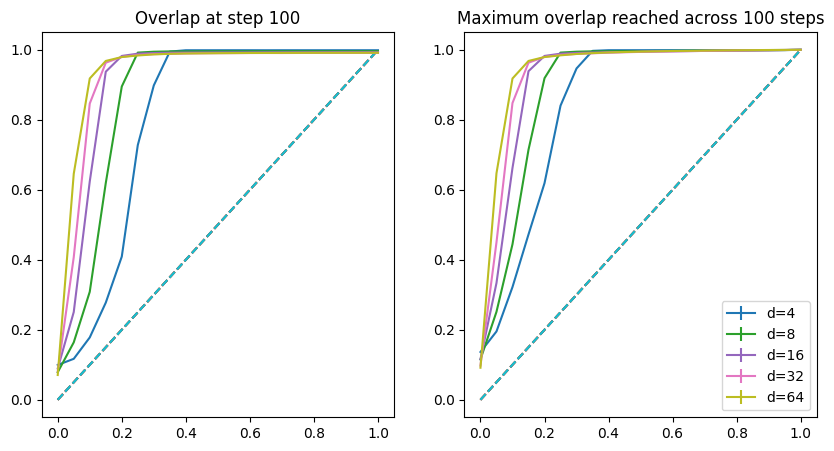

In [23]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
for i_d, d_val in enumerate(d_arr):
    axs[0].errorbar(init_overlaps_array, curves[i_d,:,0].mean(-1), curves[i_d,:,0].std(-1), label="d={}".format(d_val))
    axs[0].plot(init_overlaps_array, init_overlaps_array, "--")
    axs[0].set_title("Overlap at step 100")
    axs[1].errorbar(init_overlaps_array, curves[i_d,:,1].mean(-1), curves[i_d,:,1].std(-1), label="d={}".format(d_val))
    axs[1].plot(init_overlaps_array, init_overlaps_array, "--")
    axs[1].set_title("Maximum overlap reached across 100 steps")

plt.legend()


# Results, MSE

## d=1, vect

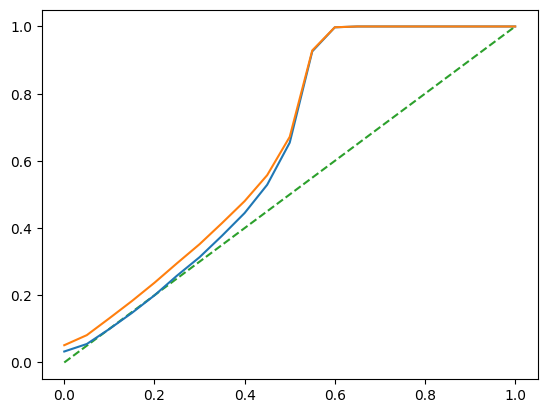

In [ ]:
#alpha=0.4
plt.errorbar(init_overlaps_array, final_ov.mean(-1), final_ov.std(-1))
plt.errorbar(init_overlaps_array, max_ov.mean(-1), max_ov.std(-1))
plt.plot(init_overlaps_array, init_overlaps_array, "--")

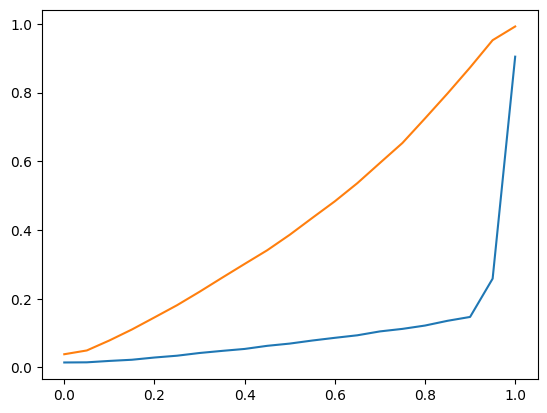

In [ ]:
#alpha=0.7
plt.plot(init_overlaps_array, final_ov.squeeze())
plt.plot(init_overlaps_array, max_ov.squeeze())
plt.plot(init_overlaps_array, init_overlaps_array, "--")

## d=8, vect

Text(0.5, 1.0, 'd: 8, $\\alpha:$ 0.8, vector variables, MSE loss')

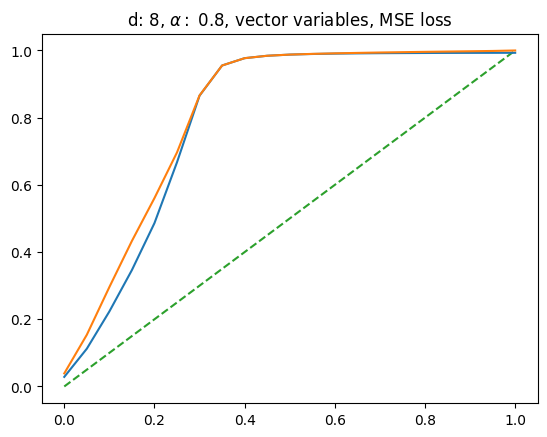

In [46]:
plt.errorbar(init_overlaps_array, final_ov.mean(-1), final_ov.std(-1))
plt.errorbar(init_overlaps_array, max_ov.mean(-1), max_ov.std(-1))
plt.plot(init_overlaps_array, init_overlaps_array, "--")
plt.title(r"d: {}, $\alpha:$ {}, {} variables, {} loss".format(d,float(P)/N,spin_type, loss_type))

## d=1, cont

Text(0.5, 1.0, 'd: 1, $\\alpha:$ 0.4, continuous variables, MSE loss')

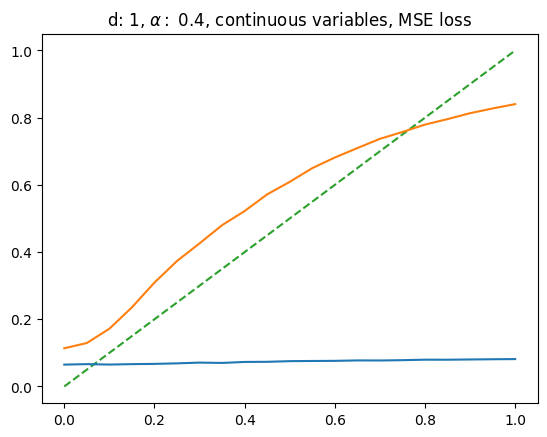

In [22]:
plt.errorbar(init_overlaps_array, final_ov.mean(-1), final_ov.std(-1))
plt.errorbar(init_overlaps_array, max_ov.mean(-1), max_ov.std(-1))
plt.plot(init_overlaps_array, init_overlaps_array, "--")
plt.title(r"d: {}, $\alpha:$ {}, {} variables, {} loss".format(d,float(P)/N,spin_type, loss_type))

## d=8, cont

Text(0.5, 1.0, 'd: 8, $\\alpha:$ 0.4, continuous variables, MSE loss')

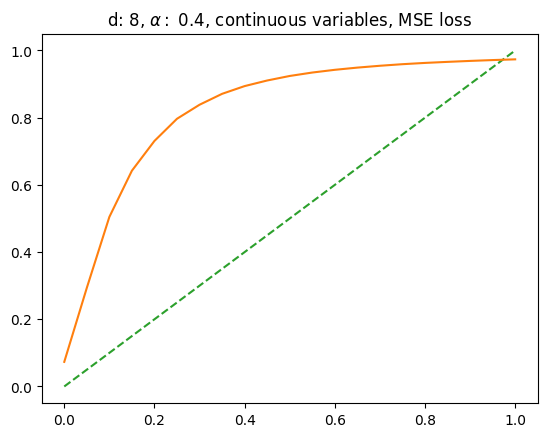

In [19]:
plt.errorbar(init_overlaps_array, final_ov.mean(-1), final_ov.std(-1))
plt.errorbar(init_overlaps_array, max_ov.mean(-1), max_ov.std(-1))
plt.plot(init_overlaps_array, init_overlaps_array, "--")
plt.title(r"d: {}, $\alpha:$ {}, {} variables, {} loss".format(d,float(P)/N,spin_type, loss_type))

# Results, CE

Text(0.5, 1.0, 'd: 4, $\\alpha:$ 0.4, vector variables, CE loss')

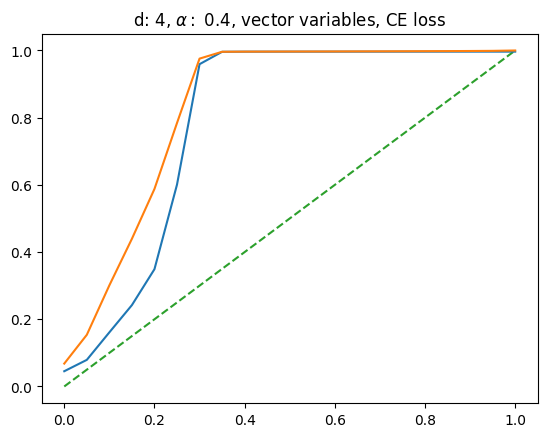

In [ ]:

plt.errorbar(init_overlaps_array, final_ov.mean(-1), final_ov.std(-1))
plt.errorbar(init_overlaps_array, max_ov.mean(-1), max_ov.std(-1))
plt.plot(init_overlaps_array, init_overlaps_array, "--")
plt.title(r"d: {}, $\alpha:$ {}, {} variables, {} loss".format(d,float(P)/N,spin_type, loss_type))